# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является шаблоном (Baseline) к текущему соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **Baseline** создается больше как шаблон, где можно посмотреть, как происходит обращение с входящими данными и что нужно получить на выходе. При этом ML начинка может быть достаточно простой. Это помогает быстрее приступить к самому ML, а не тратить ценное время на инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если наше решение хуже baseline -  мы явно делаем что-то не так и стоит попробовать другой путь) 

## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [1]:
#!pip install -q tensorflow==2.2

In [2]:
#аугментации изображений
#!pip install albumentations -q

In [3]:
#!pip install catboost

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import warnings

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.9 | packaged by conda-forge | (default, Feb 13 2021, 20:03:11) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1


In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [8]:
!pip freeze > requirements.txt
# Убирает некритические сообщения
warnings.filterwarnings("ignore")

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [9]:
#%%script false
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

# DATA_DIR = 'drive/My Drive/Colab Notebooks/Project_7_Bat_Mobile/sf-dst-car-price-prediction-part2/'
# train = pd.read_csv(DATA_DIR + 'train.csv')
# test = pd.read_csv(DATA_DIR + 'test.csv')
# sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [12]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [13]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [14]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

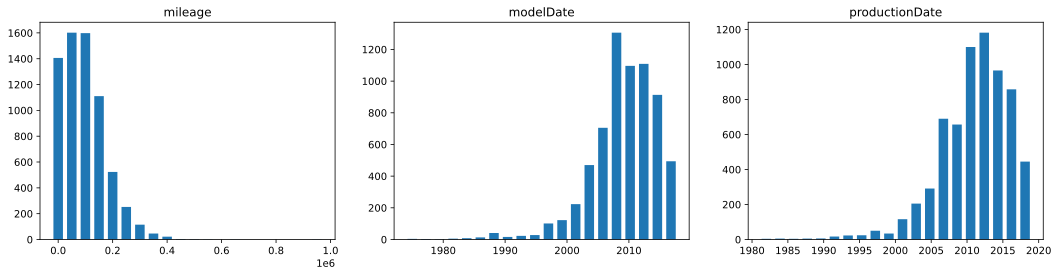

In [15]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [16]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [17]:
#посмотрим внимательнее на данные
display(data.head(3))

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,...,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый,0,0.0
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,...,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый,0,0.0
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5 LTR,218 N12,бензин,166600,2005,3ER,...,1100195294,COUPE AUTOMATIC 2.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый,0,0.0


In [18]:
print(data.shape)
print(data.isna().sum())
print(data.info())
print(data.nunique())

(8353, 23)
bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                5418
ПТС                        0
Привод                     0
Руль                       0
sample                     0
price                      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object

In [19]:
display(data[data['Владельцы'].isnull()])

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
6665,седан,AUDI,чёрный,машина в идеале! вложено примерно 400тыс.руб \...,4.2 LTR,360 N12,бензин,160000,1999,S8,...,1019330519,SEDAN AUTOMATIC 4.2,автоматическая,NaN,10 лет и 7 месяцев,Оригинал,полный,Левый,1,600000.0


In [20]:
data.loc[(data['Владельцы'].isnull()), 'Владельцы'] = '3'#заполнили пропуск

In [21]:
data['Владельцы'] = data['Владельцы'].apply(lambda x: x[0])

#train.owners_number = train.owners_number.values.round(0).astype('int64')
data['Владельцы'] = data['Владельцы'].values.astype('int64')
data.head(2)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,...,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3,6 лет и 3 месяца,Оригинал,задний,Левый,0,0.0
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,...,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1,6 лет и 6 месяцев,Оригинал,полный,Левый,0,0.0


In [22]:


data.enginePower.value_counts(dropna=False)[:20]


data['enginePower'] = data['enginePower'].str.replace(' N12','')



data['enginePower'] = data['enginePower'].astype('int64')



data.enginePower.value_counts(dropna=False)


#data['enginePower'] /= 100


data.head(2)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220,бензин,350000,1984,W124,...,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3,6 лет и 3 месяца,Оригинал,задний,Левый,0,0.0
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313,дизель,15000,2011,6ER,...,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1,6 лет и 6 месяцев,Оригинал,полный,Левый,0,0.0


In [23]:
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: x[:3])
data.engineDisplacement.value_counts(dropna=False)[:40]



len(data[data['engineDisplacement'] == 'und'])

# Есть LT. заменим LT на наиболее частое 2.0 и приведем к типу float
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: 2.0 if x == 'und' else x)
data['engineDisplacement'] = data['engineDisplacement'].astype('float32')


data.engineDisplacement.value_counts()
data.head(2)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0,220,бензин,350000,1984,W124,...,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3,6 лет и 3 месяца,Оригинал,задний,Левый,0,0.0
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0,313,дизель,15000,2011,6ER,...,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1,6 лет и 6 месяцев,Оригинал,полный,Левый,0,0.0


In [24]:
# расчитаем возраст автомобиля
data['yearsProduction'] = 2021 - data['productionDate']

# сам productionDate можно удалить: новый признак его заменяет полностью
#data.drop('productionDate', axis=1, inplace=True)


In [25]:
# расчитаем возраст модели
data['yearsModel'] = 2021 - data['modelDate']

# сам productionDate можно удалить: новый признак его заменяет полностью
#data.drop('modelDate', axis=1, inplace=True)

In [26]:
def tokenize_ru_1(file_text):
  #переведем все в нижний регистр Автомобили с пробегом гарантию юридической чистоты Первоначальный взнос Trade-In Автодилер года 
  #ВСЕ наши машины Автомобиль прошел комплексную диагностику отдела продаж
  file_text = file_text.lower()
  if ('официальный дилер' in file_text) or ('автомобили с пробегом' in file_text) or ('гарантию юридической чистоты' in file_text) or ('первоначальный взнос' in file_text) or ('автодилер года' in file_text) or ('trade-in' in file_text) or ('все наши машины' in file_text) or ('автомобиль прошел комплексную диагностику' in file_text) or ('отдела продаж' in file_text) or ('онлайн-покупка автомобиля' in file_text) or ('менеджер' in file_text):
    data.at[j, 'Дилер'] = 1
    #data['Дилер'] = 1
  else:
    data.at[j, 'Дилер'] = 0

In [27]:
j = 0
for j in range(len(data.description)):
  tokenize_ru_1(data.description[j])

In [28]:
def mile_age(x):
    if x < 20000: x = 1
    elif 19999 < x < 40000: x = 2
    elif 39999 < x < 60000: x = 3
    elif 59999 < x < 80000: x = 4
    elif 79999 < x < 100000: x = 5
    elif 99999 < x < 200000: x = 6
    elif 199999 < x < 500000: x = 7
    elif 499999 < x: x = 8
    return x  
data['mileage_category'] = data['mileage'].map(mile_age)

In [29]:
data['mileage_category'].value_counts()

6    3361
7    1246
5     868
4     767
1     753
3     700
2     651
8       7
Name: mileage_category, dtype: int64

In [30]:
data.head(2)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,Владение,ПТС,Привод,Руль,sample,price,yearsProduction,yearsModel,Дилер,mileage_category
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0,220,бензин,350000,1984,W124,...,6 лет и 3 месяца,Оригинал,задний,Левый,0,0.0,30,37,0.0,7
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0,313,дизель,15000,2011,6ER,...,6 лет и 6 месяцев,Оригинал,полный,Левый,0,0.0,8,10,0.0,1


In [31]:
#Для бинарных признаков мы будем использовать LabelEncoder

# bin_cols = ['ПТС', 'Привод', 'Руль', 'fuelType', 'vehicleTransmission', 'color']
# label_encoder = LabelEncoder()

# for column in bin_cols:
#     data[column] = label_encoder.fit_transform(data[column])
    
# # убедимся в преобразовании    
# data.head(5)

In [32]:
#numerical_features = ['yearsProduction', 'yearsModel', 'mileage', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'numberOfDoors', 'vehicleTransmission',
#                      'Владельцы', 'ПТС', 'Привод', 'Руль', 'yearsMileage']
#numerical_features = ['yearsProduction', 'yearsModel', 'engineDisplacement', 'enginePower', 'mileage']

In [33]:
#логарифмируем 



# for i in numerical_features:
#     data[i] = np.log(data[i] + 1)

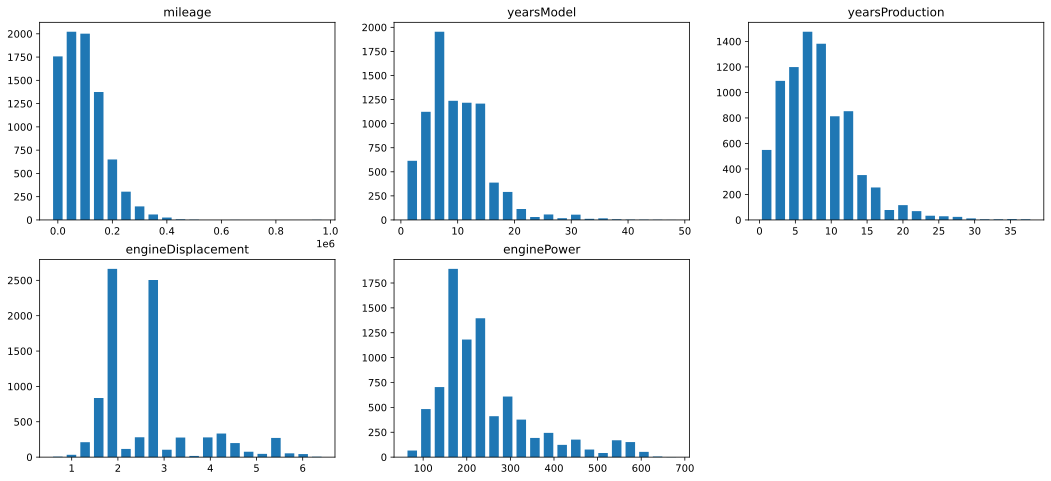

In [34]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': data['mileage'].dropna(),
    'yearsModel': data['yearsModel'].dropna(),
    'yearsProduction': data['yearsProduction'].dropna(),
    'engineDisplacement': data['engineDisplacement'].dropna(),
    'enginePower': data['enginePower'].dropna()
})

In [35]:
#numerical = ['yearsProduction', 'yearsModel', 'mileage', 'engineDisplacement', 'enginePower', 'fuelType', 'numberOfDoors', 'vehicleTransmission',
#                      'Владельцы', 'ПТС', 'Привод', 'Руль', 'price', 'Дилер', 'mileage_category', 'color']
numerical = ['yearsProduction', 'yearsModel', 'mileage', 'engineDisplacement', 'enginePower', 'numberOfDoors', 'mileage_category', 'productionDate', 'modelDate', 'Дилер', 'price']

<AxesSubplot:>

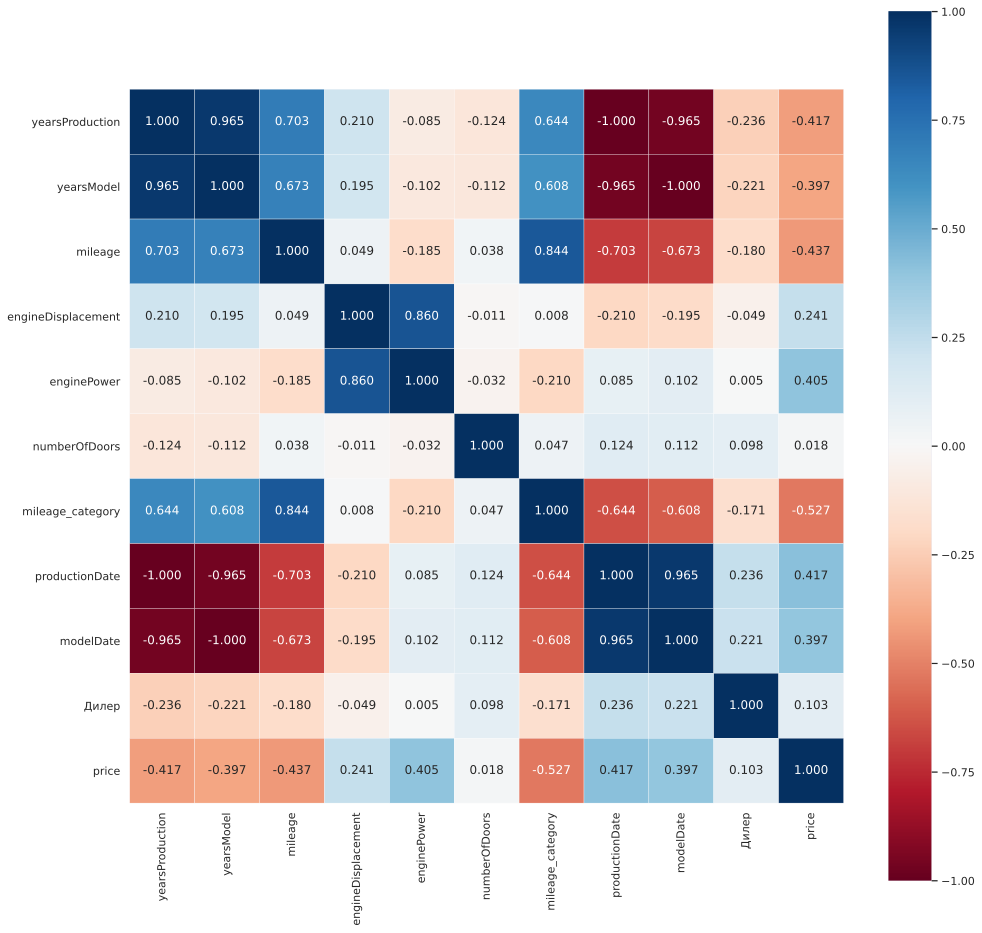

In [36]:
sns.set(font_scale=1)
plt.subplots(figsize=(16, 16))
sns.heatmap(data[numerical].corr(method='pearson'), square=True,
              annot=True, fmt=".3f", linewidths=0.3, cmap="RdBu")

<AxesSubplot:>

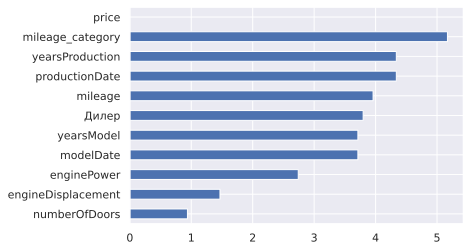

In [37]:
from sklearn.feature_selection import f_classif, mutual_info_classif

imp_num = Series(f_classif(data[numerical], data['price'])[0], index = numerical)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')



In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   float32
 5   enginePower           8353 non-null   int64  
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

In [39]:
# numerical_features = ['yearsModel', 'mileage', 'enginePower', 'fuelType', 'numberOfDoors', 'vehicleTransmission',
#                       'Владельцы', 'ПТС', 'Привод', 'Дилер', 'color', 'Руль', 'mileage_category']

# categorical_features = ['brand', 'bodyType', 'model_info']

categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 'Владельцы', 
                        'numberOfDoors', 'vehicleTransmission', 'ПТС', 'Привод', 'Руль','mileage_category', 'Дилер']
numerical_features = ['mileage', 'yearsModel', 'yearsProduction', 'enginePower', 'engineDisplacement', 'productionDate', 'modelDate']

In [40]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id', 'vehicleConfiguration', 'name', 'Владение'], axis = 1, inplace=True)
    
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    #for column in numerical_features:
    #    df_output[column].fillna(df_output[column].median(), inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    #логарифмируем
    

    #for i in numerical_features:
    #    df_output[i] = np.log(df_output[i] + 1)
    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    #df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)
    
    return df_output

In [41]:
### Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(5)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,sample,price,yearsProduction,yearsModel,bodyType_0,...,mileage_category_0,mileage_category_1,mileage_category_2,mileage_category_3,mileage_category_4,mileage_category_5,mileage_category_6,mileage_category_7,Дилер_0,Дилер_1
7399,0.220339,0.2720,0.106999,0.895833,0.868421,1,1590000.0,0.131579,0.104167,0,...,0,0,0,0,0,1,0,0,1,0
4273,0.220339,0.2720,0.044999,0.875000,0.894737,1,3100000.0,0.105263,0.125000,0,...,0,0,1,0,0,0,0,0,1,0
3362,0.813559,0.8160,0.054999,0.875000,0.868421,1,3750000.0,0.131579,0.125000,0,...,0,0,1,0,0,0,0,0,1,0
2794,0.389831,0.2720,0.124999,0.833333,0.763158,1,1990000.0,0.236842,0.166667,0,...,0,0,0,0,0,1,0,0,1,0
5378,0.220339,0.2288,0.148999,0.875000,0.868421,1,1285000.0,0.131579,0.125000,0,...,0,0,0,0,0,1,0,0,1,0


In [42]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 199 entries, engineDisplacement to Дилер_1
dtypes: float32(1), float64(7), int64(1), uint8(190)
memory usage: 2.1 MB


## Split data

In [43]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)
y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [44]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 198 entries, engineDisplacement to Дилер_1
dtypes: float32(1), float64(7), uint8(190)
memory usage: 421.0 KB


# Model 2: CatBoostRegressor

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [46]:
model = CatBoostRegressor(iterations = 10000,
                          #depth=10,
                          #learning_rate = 0.0025,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.015242
0:	learn: 0.9920820	test: 1.0163898	best: 1.0163898 (0)	total: 55.5ms	remaining: 9m 15s
100:	learn: 0.3916720	test: 0.3958294	best: 0.3958294 (100)	total: 314ms	remaining: 30.7s
200:	learn: 0.2700202	test: 0.2693767	best: 0.2693767 (200)	total: 566ms	remaining: 27.6s
300:	learn: 0.2291179	test: 0.2276533	best: 0.2276533 (300)	total: 809ms	remaining: 26.1s
400:	learn: 0.2068044	test: 0.2068842	best: 0.2068842 (400)	total: 1.06s	remaining: 25.3s
500:	learn: 0.1896939	test: 0.1910827	best: 0.1910827 (500)	total: 1.31s	remaining: 24.9s
600:	learn: 0.1792822	test: 0.1815756	best: 0.1815710 (599)	total: 1.57s	remaining: 24.5s
700:	learn: 0.1739738	test: 0.1766637	best: 0.1766637 (700)	total: 1.82s	remaining: 24.1s
800:	learn: 0.1703865	test: 0.1738000	best: 0.1737945 (796)	total: 2.07s	remaining: 23.8s
900:	learn: 0.1657337	test: 0.1695502	best: 0.1695502 (900)	total: 2.32s	remaining: 23.4s
1000:	learn: 0.1607701	test: 0.1649856	best: 0.1649856 (1000)	total: 2.5

In [47]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")


TEST mape: 12.42%


<AxesSubplot:>

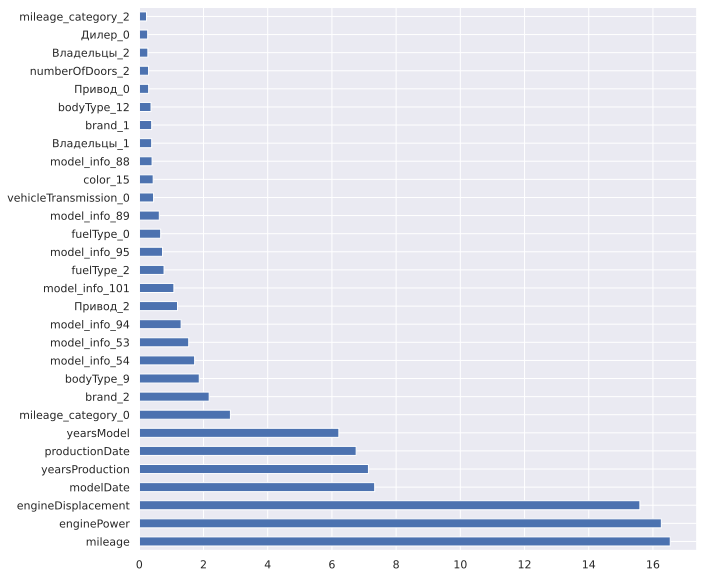

In [48]:
# в CatboostRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

### Submission

In [49]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [50]:
X_train.head(3)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,yearsProduction,yearsModel,bodyType_0,bodyType_1,bodyType_2,...,mileage_category_0,mileage_category_1,mileage_category_2,mileage_category_3,mileage_category_4,mileage_category_5,mileage_category_6,mileage_category_7,Дилер_0,Дилер_1
7320,0.898305,0.7504,0.149999,0.770833,0.763158,0.236842,0.229167,0,0,0,...,0,0,0,0,0,1,0,0,1,0
8037,0.220339,0.2720,0.020941,0.937500,0.947368,0.052632,0.062500,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4681,0.406780,0.2880,0.133896,0.687500,0.631579,0.368421,0.312500,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

## Simple Dense NN

In [52]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               101376    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 232,961
Trainable params: 232,961
Non-trainable params: 0
_________________________________________________________________


In [54]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [55]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [56]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

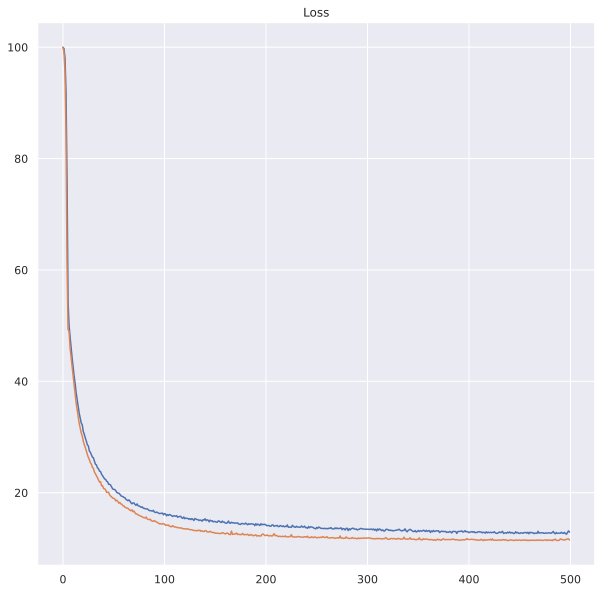

In [57]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [58]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [59]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.51%


In [60]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Model 4: NLP + Multiple Inputs

In [61]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [62]:
type(data.description)

pandas.core.series.Series

In [63]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [64]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [65]:
!nvidia-smi

Wed Jun 23 07:51:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    32W / 250W |  15371MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [66]:
!pip install --upgrade nltk

     |████████████████████████████████| 1.5 MB 6.0 MB/s 
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.6.2 which is incompatible.


In [67]:
import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk

True

In [68]:

#стоп-слова
from nltk.corpus import stopwords
print(stopwords.words("russian"))


['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [69]:
import re
import gensim
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet

In [70]:
def tokenize_ru(file_text):

    #переведем все в нижний регистр
  file_text = file_text.lower()
    
  file_text = file_text.replace('автомобиль в отличном состоянии','отличноесостояние')      
  file_text = file_text.replace('машина в отличном состаянии', 'отличноесостояние')        
  file_text = file_text.replace('машина в отличном состоянии', 'отличноесостояние')
  file_text = file_text.replace('продаю машину в отличном состоянии', 'отличноесостояние')
  file_text = file_text.replace('авто в идеальном состоянии', 'отличноесостояние')
  file_text = file_text.replace('идеальное состояние', 'отличноесостояние')
  file_text = file_text.replace('состояние отличное', 'отличноесостояние')
  file_text = file_text.replace('автомобиль в исключительно идеальном состоянии', 'отличноесостояние')
  file_text = file_text.replace('в состоянии нового автомобиля', 'отличноесостояние')
  file_text = file_text.replace('в отличном состоянии', 'отличноесостояние')
  file_text = file_text.replace('в прекрасном состоянии', 'отличноесостояние')
  file_text = file_text.replace('автомобиль в отличном техническом состоянии', 'отличноесостояние')
  file_text = file_text.replace('состояние идеальное', 'отличноесостояние')
  file_text = file_text.replace('в идеальном состоянии', 'отличноесостояние')
  file_text = file_text.replace('идеальное техническое состояние', 'отличноесостояние')
  file_text = file_text.replace('все в идеале', 'отличноесостояние') 
  file_text = file_text.replace('машина', 'автомобиль')
  file_text = file_text.replace('автомобиля', 'автомобиль')
  file_text = file_text.replace(' авто ', 'автомобиль')
  file_text = file_text.replace('автомобилей', 'автомобиль')
  file_text = file_text.replace('автомобили', 'автомобиль')
  file_text = file_text.replace('обмен вашего', 'обмен')
       

  file_text = re.sub(r'[-+]?\d+', " ", file_text)
  file_text = re.sub(r'\s\D\s', " ", file_text)
  file_text = re.sub(r'\s\w\s', " ", file_text)
  file_text = re.sub(r'\_{1,}', " ", file_text)
  file_text = re.sub(r'\*{1,}', " ", file_text)
  file_text = re.sub(r'\—{1,}', " ", file_text)
  file_text = re.sub(r'\❗️{1,}', " ", file_text)
  file_text = re.sub(r'\▼{1,}', " ", file_text)
  # firstly let's apply nltk tokenization
  tokens = word_tokenize(file_text)
 

  # let's delete punctuation symbols
  tokens = [i for i in tokens if (i not in string.punctuation)]



  # deleting stop_words
  stop_words = stopwords.words('russian')
  stop_words.extend(['☑️', '✔', '➥', '●', '✅', '☛','``', '•', '⭐️', '⭐️ ', '🎁', '🥇', '▼', '...', '–', '∙', '—', '”', '″', '“', '·', '₽', '❤️',
                    "''", 'мы', 'нам', 'км', 'руб', 'ваш', '✪', '。'])#'———————————————————————————', "''", '———————————————————————————', 'мы', 'нам', 'км', 'руб', 'ваш'
  tokens = [i for i in tokens if (i not in stop_words)]

  stop_words = stopwords.words('english')
  tokens = [i for i in tokens if (i not in stop_words)]

    # cleaning words
  tokens = [i.replace("«", "").replace("»", "") for i in tokens]
  #лемматизация
  tokens = ' '.join([lemmatizer.lemmatize(i) for i in tokens])
  

 

  return tokens

In [71]:
len(data.description)

8353

In [72]:
lemmatizer = WordNetLemmatizer()
#tokenize_ru(data.description[1256])
#pattern = r"[-+]?\d+"

j=0
for j in range(len(data.description)):
  #print(j)
  #tokenize_ru(j)
  
  data.description[j] = tokenize_ru(data.description[j])

In [73]:
data.description[18] 

'автокредит первоначальный взнос выгода рублей покупкеавтомобильв trade-in выгода рублей покупке кредит оформление двум документам срок кредитования месяцев лет минимальный пакет документов паспорт вод удостоверение досрочное погашение штрафов комиссий банка-партнера первый платеж подарок каско экспресс-кредит оформление сделки одним днем представленные автомобиль наличии цены соответствуют независимо способа оплаты наши автомобиль предоставляем гарантию юридической чистоты оставить заявку сайте телефону приглашаем тест-драйв'

In [74]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.22 s, sys: 13 ms, total: 1.23 s
Wall time: 1.24 s


In [75]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.24 s, sys: 2.66 ms, total: 1.24 s
Wall time: 1.24 s


In [76]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

.

• Автомобиль проверен по 110 пунктам
• Автокредит по специальной ставке от 13,7%

Ауди Центр Север, официальный дилер Audi, входящий в группу компаний РОЛЬФ и являющийся одним из крупнейших дилеров в Европе, предлагает Вам ряд услуг по покупке и продаже автомобилей с пробегом.

На протяжении многих лет наш дилерский центр является лидером по продаже автомобилей с пробегом среди всех дилеров Audi в России и предоставляет клиентам самый большой выбор автомобилей с пробегом Audi и других марок.
Каждый автомобиль проходит тщательную диагностику и подготовку, и гарантировано находится в отличном состоянии.
Чтобы убедиться в правильном выборе, у Вас есть возможность пройти тест-драйв ― ознакомительную поездку на интересующем автомобиле.
Вы сможете ознакомиться с автомобилем не выходя из дома – наш менеджер проведет online презентацию и в видеозвонке покажет выбранный автомобиль.
Также Ауди Центр Север представляет уникальное предложение по кредитованию автомобилей с пробегом на индивидуал

### RNN NLP

In [77]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [78]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(128, activation="relu"))
model_mlp.add(L.Dropout(0.25))

### Multiple Inputs NN

In [79]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [80]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     8514304     seq_description[0][0]            
__________________________________________________________________________________________________
dense_4_input (InputLayer)      [(None, 197)]        0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
______________________________________________________________________________________________

### Fit

In [81]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [82]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [83]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 10s 438ms/step - loss: 99.9858 - MAPE: 99.9858 - val_loss: 99.1512 - val_MAPE: 99.1512
Epoch 2/500
12/12 [==============================] - 4s 319ms/step - loss: 92.8372 - MAPE: 92.8372 - val_loss: 55.0038 - val_MAPE: 55.0038
Epoch 3/500
12/12 [==============================] - 4s 324ms/step - loss: 55.4784 - MAPE: 55.4784 - val_loss: 46.2858 - val_MAPE: 46.2858
Epoch 4/500
12/12 [==============================] - 4s 318ms/step - loss: 44.7158 - MAPE: 44.7158 - val_loss: 39.1254 - val_MAPE: 39.1254
Epoch 5/500
12/12 [==============================] - 4s 328ms/step - loss: 38.4408 - MAPE: 38.4408 - val_loss: 32.8193 - val_MAPE: 32.8193
Epoch 6/500
12/12 [==============================] - 4s 319ms/step - loss: 33.2405 - MAPE: 33.2405 - val_loss: 28.9561 - val_MAPE: 28.9561
Epoch 7/500
12/12 [==============================] - 4s 321ms/step - loss: 30.7833 - MAPE: 30.7833 - val_loss: 26.2787 - val_MAPE: 26.2787
Epoch 8/500
12/12 [=======

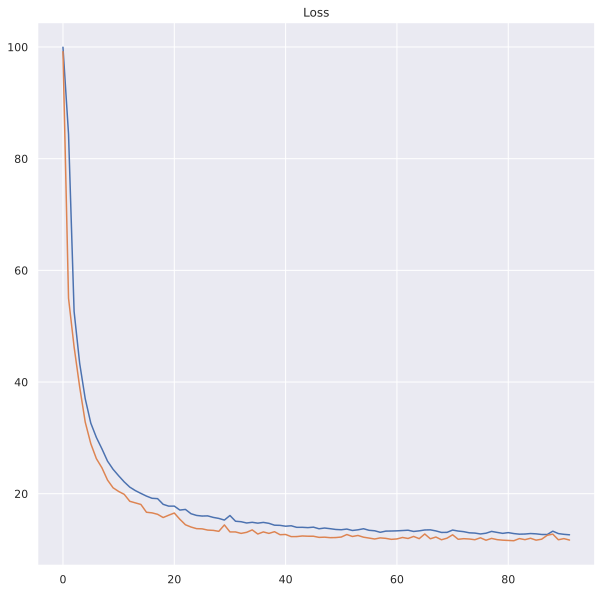

In [84]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [85]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [86]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 11.70%


In [87]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

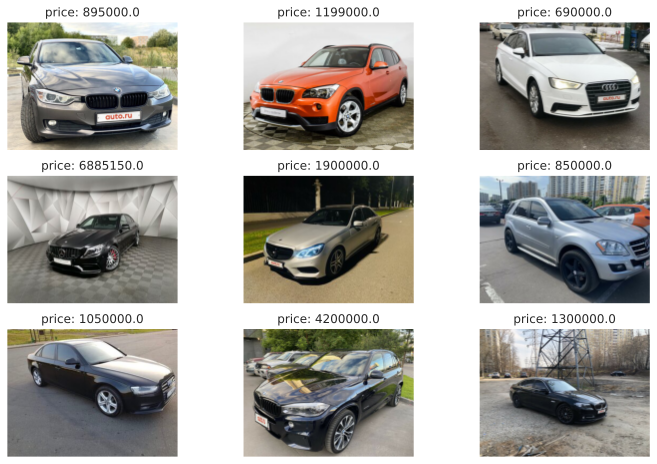

In [88]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [89]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

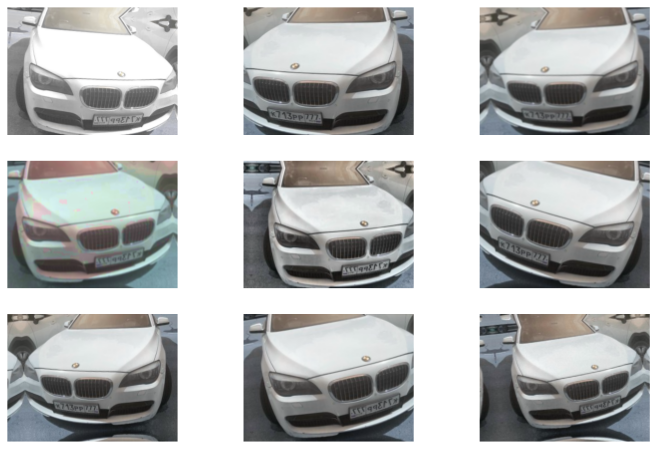

In [90]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [91]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [92]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [93]:
data.description

0       всем привет продам эксклюзивный проект универс...
1       продаю любимейшую тачилу .. обвес тюнинг hamma...
2       автомобиль продаётся первый перебран двигатель...
3       отличноесостояние весь родной краске красился ...
4       немка бесключивым доступом камерой заднего вид...
                              ...                        
8348    продаётся любимый автомобиль годы эксплуатация...
8349    куплена официального дилера г. третий владелец...
8350    торг месте работает сборка немецкая резина лет...
8351    отличноесостояние -изавтомобильв семье обслужи...
8352    удлиненный заводской pullman базе вообще-то пр...
Name: description, Length: 8353, dtype: object

In [94]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [95]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 0s 0us/step


In [96]:
print("Количество слоев в базе: ", len(efficientnet_model.layers))

Количество слоев в базе:  384


In [97]:
# возьмем половину слоев у базовой модели
efficientnet_model.trainable = True
#настройка, начиная с этого слоя
fine_tune_at = len(efficientnet_model.layers)//2
# Заморозим все слои перед тонкой надстройкой
for layer in efficientnet_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [98]:
#смотрим количество слоев
len(efficientnet_model.trainable_variables)

171

In [99]:


for layer in model.layers:
    print(layer, layer.trainable)



<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9b47a28610> True
<tensorflow.python.keras.layers.embeddings.Embedding object at 0x7f9fa44d9710> True
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9b41e54990> True
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x7f9fa44643d0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9b420715d0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9b46b74350> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9b41e4f510> True
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x7f9fa449ecd0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9b41eeabd0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9b41fab190> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9b41e60750> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9fa44a4dd0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7

In [100]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [101]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [102]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

In [103]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [104]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [105]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - 140s 667ms/step - loss: 73.0678 - MAPE: 73.0678 - val_loss: 29.8171 - val_MAPE: 29.8171
Epoch 2/100
190/190 [==============================] - 126s 661ms/step - loss: 29.8351 - MAPE: 29.8351 - val_loss: 22.3160 - val_MAPE: 22.3160
Epoch 3/100
190/190 [==============================] - 122s 639ms/step - loss: 23.9347 - MAPE: 23.9347 - val_loss: 18.7442 - val_MAPE: 18.7442
Epoch 4/100
190/190 [==============================] - 125s 655ms/step - loss: 20.7886 - MAPE: 20.7886 - val_loss: 18.1837 - val_MAPE: 18.1837
Epoch 5/100
190/190 [==============================] - 124s 650ms/step - loss: 19.0166 - MAPE: 19.0166 - val_loss: 16.4606 - val_MAPE: 16.4606
Epoch 6/100
190/190 [==============================] - 126s 658ms/step - loss: 17.2090 - MAPE: 17.2090 - val_loss: 14.4707 - val_MAPE: 14.4707
Epoch 7/100
190/190 [==============================] - 122s 639ms/step - loss: 16.1332 - MAPE: 16.1332 - val_loss: 13.5755 - val_MAPE: 13.5755

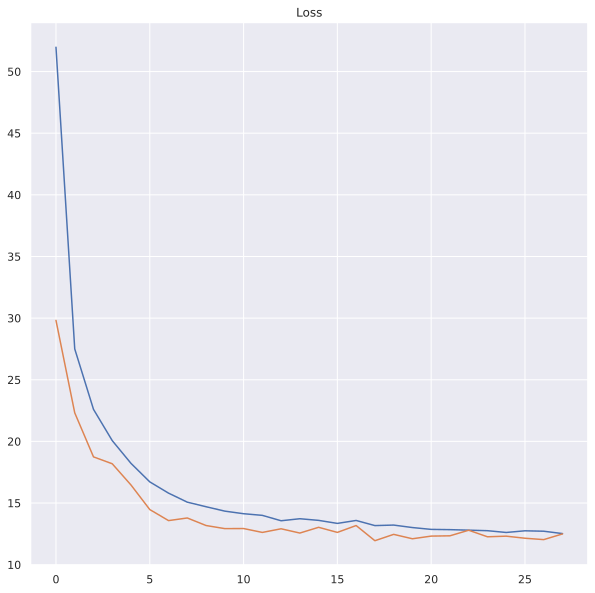

In [106]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [107]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [108]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 12.49%


In [109]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [110]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 11.14%


In [111]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [112]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [113]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="yearsModel")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.yearsModel.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [114]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [115]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_14_input (InputLayer)     [(None, 197)]        0                                            
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 512)          101376      dense_14_input[0][0]             
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 512)          0           dense_14[0][0]                   
__________________________________________________________________________________________________
yearsModel (InputLayer)         [(None, 1)]          0                                            
____________________________________________________________________________________________

In [116]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [117]:
history = model.fit([X_train, X_train.yearsModel.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.yearsModel.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 1s 20ms/step - loss: 99.9957 - MAPE: 99.9957 - val_loss: 99.8471 - val_MAPE: 99.8471
Epoch 2/500
12/12 [==============================] - 0s 8ms/step - loss: 99.2638 - MAPE: 99.2638 - val_loss: 93.1469 - val_MAPE: 93.1469
Epoch 3/500
12/12 [==============================] - 0s 7ms/step - loss: 85.2053 - MAPE: 85.2053 - val_loss: 50.2298 - val_MAPE: 50.2298
Epoch 4/500
12/12 [==============================] - 0s 7ms/step - loss: 52.0890 - MAPE: 52.0890 - val_loss: 46.8743 - val_MAPE: 46.8743
Epoch 5/500
12/12 [==============================] - 0s 7ms/step - loss: 47.6784 - MAPE: 47.6784 - val_loss: 43.4969 - val_MAPE: 43.4969
Epoch 6/500
12/12 [==============================] - 0s 9ms/step - loss: 43.5867 - MAPE: 43.5867 - val_loss: 39.7323 - val_MAPE: 39.7323
Epoch 7/500
12/12 [==============================] - 0s 7ms/step - loss: 39.4856 - MAPE: 39.4856 - val_loss: 35.9809 - val_MAPE: 35.9809
Epoch 8/500
12/12 [=====================

In [118]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.yearsModel.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 11.96%


In [119]:
# 